In [1]:
import scipy.sparse as sc
import itertools as it
import pandas as pd
import numpy as np
import warnings
import shutil 
import copy
import glob
import sys
import os
import time
import tensorflow as tf
from tensorflow import keras
try: ## In order to open and save dictionaries, "dt": self.dt, "kind" : "Viscosity"
    import cPickle as pickle
except ImportError:  # python 3.x
    import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import multiprocess as mp
warnings.filterwarnings (action="ignore",message="internal issue")

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
## Things necessary to do nice plots
from matplotlib.ticker import ScalarFormatter, FuncFormatter
from  matplotlib.transforms import Affine2D

IMAGES ="images/"

from matplotlib import rcParams
plt.rc ('axes', labelsize = 12)
plt.rc ('xtick', labelsize = 12)
plt.rc ('ytick', labelsize = 12)
plt.rc ('font', size = 12)
plt.rc ('grid', alpha = 0.6)
plt.rc ('legend', fontsize = 12)
rcParams ['font.family'] =  "Times New Roman"
rcParams ['mathtext.fontset'] = 'custom' 
rcParams ['lines.linewidth'] = 2
rcParams ['lines.markersize'] = 12
rcParams ['lines.markeredgewidth'] = 2

In [2]:
import sys
sys.path.insert (0, "MOTHER_PSBC/")

from  tfversion_binary_phase_separation import *
from tf_PSBC_extra_libs_for_training_and_grid_search import *
from PSBC_plots_useful import *

This function will be useful for labeling

In [3]:
def test_label(x):
    return r'$2^{{-{0}}}$'.format(x)

# Open dictionaries

In [4]:
with open ("Statistics/All_accuracies.p", 'rb') as pickled_dic:
    All_accuracies = pickle.load (pickled_dic)
    
with open ("Statistics/Best_parameters.p", 'rb') as pickled_dic:
    Best_parameters = pickle.load (pickled_dic)

with open ("Statistics/All_filepaths_best_weights.p", 'rb') as pickled_dic:
    All_filepaths_best_weights = pickle.load (pickled_dic)

with open ("Statistics/All_histories.p", 'rb') as pickled_dic:
    All_histories = pickle.load (pickled_dic)
    
with open ("Statistics/Snapshot_best_weights.p", 'rb') as pickled_dic:
    Snapshot_best_weights = pickle.load (pickled_dic)    
    
with open ("Statistics/Snapshot_best_weights_stats.p", 'rb') as pickled_dic:
    Snapshot_best_weights_stats = pickle.load (pickled_dic)    

# Getting all accuracies

In [7]:
All_accuracies ["Neumann"][2][(0,1)][2].keys ()

dict_keys(['train_set_std', 'train_set', 'test_set', 'test_set_std', 'test_set_mean', 'train_set_mean'])

In [5]:
All_accuracies ["Neumann"][2][(0,1)][2]["test_set_mean"]

array([[0.9926241 , 0.99224585, 0.9920567 , 0.9917731 , 0.9884634 ,
        0.9771158 ],
       [0.9914893 , 0.9913002 , 0.9912057 , 0.99044913, 0.98855793,
        0.9786288 ],
       [0.9895981 , 0.98770684, 0.9886525 , 0.9872341 , 0.98430264,
        0.9716312 ],
       [0.9696454 , 0.96917266, 0.97030735, 0.9699291 , 0.96869975,
        0.9643499 ],
       [0.92879426, 0.9304018 , 0.92643034, 0.9249172 , 0.92520094,
        0.9202837 ]], dtype=float32)

In [6]:
All_accuracies ["PCA_196"][2][(3,5)][1]

{'test_set': array([[0.8485804 ],
        [0.84437436],
        [0.84437436],
        [0.84963197],
        [0.84542584]], dtype=float32),
 'test_set_mean': array([0.8464774], dtype=float32),
 'test_set_std': array([0.00220569], dtype=float32),
 'train_set': array([[0.8345741 ],
        [0.83543974],
        [0.8355263 ],
        [0.8374308 ],
        [0.8326697 ]], dtype=float32),
 'train_set_mean': array([0.8351281], dtype=float32),
 'train_set_std': array([0.00154329], dtype=float32)}

We plot the surface of accuracies as follows

Saving figure as  PSBC_accuracy_Nt_4


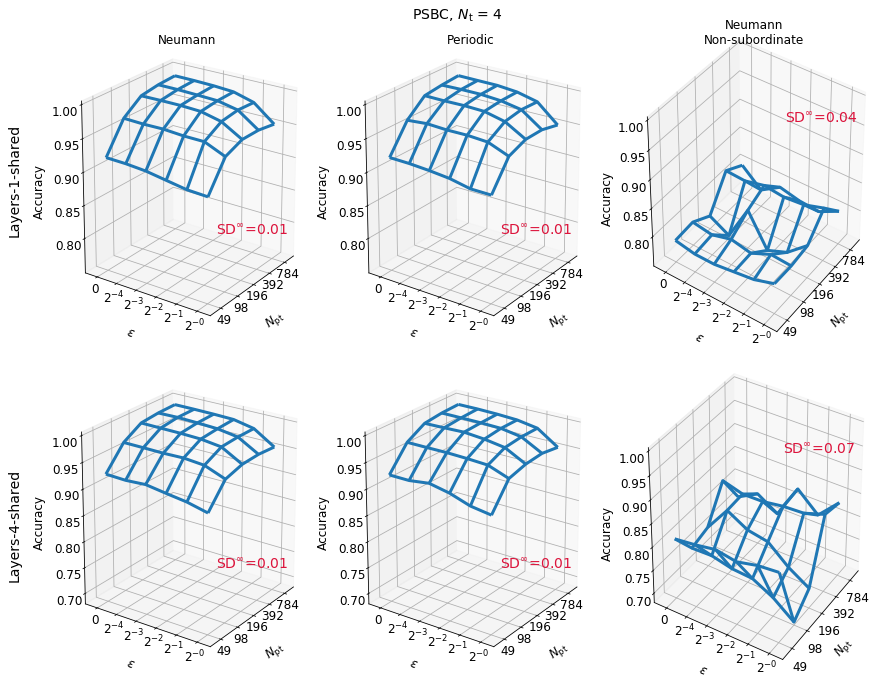

In [12]:
Nt = 4

if Nt == 1:
    axis_view = {0: (20, 35), 1: (20, 35), 2: (25, 65)}
    height_SD = {0: .02, 1: 0.01, 2: .01}
    x_labelpad, y_labelpad, z_labelpad = 2, 2, 10
elif Nt == 2:
    axis_view = {0: (20, 35), 1: (20, 35), 2: (13, 34), 3: (20, 35), 4: (20, 35), 5: (30, 34)}
    height_SD = {0: None, 1: None, 2: .38, 3: .01, 4: .01, 5: .13}
    x_labelpad, y_labelpad, z_labelpad = 4, 4, 10
elif Nt == 4:
    axis_view = {0: (20, 35), 1: (20, 35), 2: (35, 35), 3: (20, 35), 4: (20, 35), 5: (32, 32)}
    height_SD = {0 : .03, 1 :  .03, 2 : .2, 3 :  .03, 4 : .03, 5 : .25}
    x_labelpad, y_labelpad, z_labelpad = 5, 5, 10
    
min_1, min_Nt = 1, 1
print_corner = True
zlims = {1: (.75,1), 2: (.6,1), 4: (.6,1)}
nrows = 2 if Nt != 1 else 1

fig, ax = plt.subplots (ncols = 3, nrows = nrows, figsize = (15, 6 * nrows), #sharey = True,
    gridspec_kw = {'wspace' : .05, 'hspace' : .03}, subplot_kw = {'projection': '3d'})

Xs = np.arange (5)
Xlabel = [int (784 / k) for k in [1,2,4,8,16]]
Ys = np.arange (6)
Y_label = [test_label (a) for a in np.arange (4,-1,-1)]
Y_label = ["0"] + Y_label
X, Y = np.meshgrid (Xs, Ys)

SD_infty = np.zeros ((2,3), dtype = np.float32)
for col, name  in enumerate (zip (["Neumann", "Periodic", "Neumann_non_subordinate"],\
                                 ["Neumann", "Periodic", "Neumann\nNon-subordinate"])):    
    col_name, col_title = name 
    
    if Nt == 1: 
        ax [col].set_title (col_title, y = 1.0)
        fig.suptitle (r"PSBC, $N_{\mathrm{t}}$ = " + str (Nt), y = .94, size = 14)
    else: 
        ax [0,col].set_title (col_title, y = 1.0)
        fig.suptitle (r"PSBC, $N_{\mathrm{t}}$ = " + str (Nt), y = .9, size = 14)
    
    for row, row_name in enumerate (["Layers-1-shared", "Layers-" + str (Nt) + "-shared"]):
        if row == 0:
            lks = 1 
            
            M_now = All_accuracies [col_name][Nt][(0,1)][lks]["test_set_mean"]
            S_now = All_accuracies [col_name][Nt][(0,1)][lks]["test_set_std"]
            if np.less (np.min (M_now), min_1):
                min_1 = np.min (M_now)
        else: 
            lks = Nt
            M_now = All_accuracies [col_name][Nt][(0,1)][lks]["test_set_mean"]
            S_now = All_accuracies [col_name][Nt][(0,1)][lks]["test_set_std"]
            if np.less (np.min(M_now),min_Nt):
                min_Nt = np.min (M_now)
                
        if Nt ==1 and row ==1:
            continue
        if Nt ==1:
            ax [col].plot_wireframe(X,Y,  M_now.T, alpha = 1, linewidth =3, rstride=1, cstride=1)
            ax [col].set_xlabel ("x")
            ax [col].set_ylabel ("y")
            ax [col].set_xlabel (r"$N_{\mathrm{pt}}$",  labelpad = x_labelpad)
            ax [col].set_ylabel (r"$\varepsilon$", labelpad = y_labelpad)
            ax [col].zaxis.set_rotate_label (False)
            ax [col].set_zlabel ("Accuracy", labelpad = z_labelpad, rotation = 90)     
            SD_infty [0,col] = np.round (np.max (S_now), 2)
        else:
            ax [row, col].plot_wireframe (
                X,Y, M_now.T, alpha = 1,
                linewidth = 3, rstride = 1, cstride = 1)
            ax [row,col].set_xlabel (r"$N_{\mathrm{pt}}$", labelpad = x_labelpad)
            ax [row,col].set_ylabel (r"$\varepsilon$", labelpad = y_labelpad)
            ax [row,col].zaxis.set_rotate_label (False)
            ax [row,col].set_zlabel ("Accuracy", labelpad = z_labelpad, rotation = 90)
            SD_infty[row,col] = np.round (np.max (S_now ), 2)
            
if Nt == 1:
    fig.text (0.09, 0.5, "Layers-1-shared",
              ha = 'center', va = 'center', rotation = 'vertical', size = 14)
else:
    fig.text(0.09, 0.7, "Layers-1-shared",
             ha = 'center', va = 'center', rotation = 'vertical', size = 14)
    fig.text(0.09, 0.3, "Layers-" + str (Nt) + "-shared",
             ha = 'center', va = 'center', rotation = 'vertical', size = 14)
    
for col in range (3):
    if Nt ==1:
        ax [col].set_xticks (Xs)
        ax [col].set_xticklabels (Xlabel)
        ax [col].set_yticks (Ys)
        ax [col].set_yticklabels (Y_label)
        
        for t in ax [col].zaxis.get_major_ticks (): t.label.set_fontsize (12)
        for t in ax [col].xaxis.get_major_ticks (): t.label.set_fontsize (12)
        for t in ax [col].yaxis.get_major_ticks (): t.label.set_fontsize (12)
                
        ax [col].view_init(30, 25)
        ax [col].set_ylim (-.5,5.5)            
        ax [col].set_xlim (-.5,4.5)  
        ax [col].set_zlim (min_1,1)
        ax [col].view_init(axis_view[col][0], axis_view[col][1])
        ax [col].xaxis.set_tick_params (pad = -4)
        ax [col].yaxis.set_tick_params (pad = -4)
        if print_corner:
            min_now = min_1
            if height_SD[col] == None:
                ax [col].text (
                    0,4,min_now,
                    r"$\mathrm{SD}^{\infty}$=" + str (SD_infty[0, col]),
                    ha = "center", va = "center", color = "crimson", size = 14)
            else:
                min_now += height_SD [col]
                ax [col].text(
                    0,4, min_now,
                    r"$\mathrm{SD}^{\infty}$=" + str (SD_infty [0, col]),
                    ha = "center", va = "center", color = "crimson", size = 14)
    else:
        for row in range (2):
            ax [row,col].set_xticks (Xs)
            ax [row,col].set_xticklabels (Xlabel)
            ax [row,col].set_yticks (Ys)
            ax [row,col].set_yticklabels (Y_label)
            ax [row,col].view_init(
                axis_view [int (col + 3 * row)][0], axis_view [int (col + 3 * row)][1])
            ### Adjusting tick size
            for t in ax [row, col].zaxis.get_major_ticks (): t.label.set_fontsize (12)
            for t in ax [row, col].xaxis.get_major_ticks (): t.label.set_fontsize (12)
            for t in ax [row, col].yaxis.get_major_ticks (): t.label.set_fontsize (12)
                
            if row ==0:
                ax [row,col].set_zlim (min_1, 1)
            else:
                ax [row,col].set_zlim (min_Nt, 1)
            ax [row,col].set_ylim (-.5,5.5)
            ax [row, col].set_xlim (-.5,4.5)  
            ax [row,col].yaxis.set_tick_params (pad = -4)
            if row ==1 and col == 2:
                ax [row,col].xaxis.set_tick_params (pad = 1)
            else:
                ax [row,col].xaxis.set_tick_params (pad = -4)
            if print_corner:
                min_now = min_1 if row == 0 else min_Nt
                if height_SD[int(col + 3 * row)] == None:
                    ax [row, col].text (
                        0,4, min_now, 
                        r"$\mathrm{SD}^{\infty}$=" +  str (SD_infty [row, col]),
                        ha = "center", va = "center", color = "crimson", size = 14)
                else:
                    min_now += height_SD[int(col + 3 * row)]
                    ax [row, col].text(
                        0,4, min_now, 
                        r"$\mathrm{SD}^{\infty}$=" + str (SD_infty [row, col]),
                        ha = "center", va = "center", color = "crimson", size = 14)

fig_name_save = "PSBC_accuracy_Nt_" + str (Nt)                    
#figure_save (fig_name_save, resolution = 600, figure_extension = "pdf")
plt.tight_layout ()
plt.show ()

# Getting all best parameters

In [7]:
Best_parameters ["Neumann"][2][(0,1)][2]

{49: {'dt_range': array([0.2], dtype=float32),
  'eps_range': array([0.    , 0.0625, 0.125 , 0.25  , 0.5   , 1.    ], dtype=float32),
  'layer_share_range': array([2], dtype=uint16),
  'lr_P_range': array([0.1], dtype=float32),
  'lr_U_range': array([0.001], dtype=float32),
  'ptt_range': array([49], dtype=uint16)},
 98: {'dt_range': array([0.2], dtype=float32),
  'eps_range': array([0.    , 0.0625, 0.125 , 0.25  , 0.5   , 1.    ], dtype=float32),
  'layer_share_range': array([2], dtype=uint16),
  'lr_P_range': array([0.1], dtype=float32),
  'lr_U_range': array([0.001], dtype=float32),
  'ptt_range': array([98], dtype=uint16)},
 196: {'dt_range': array([0.2], dtype=float32),
  'eps_range': array([0.    , 0.0625, 0.125 , 0.25  , 0.5   , 1.    ], dtype=float32),
  'layer_share_range': array([2], dtype=uint16),
  'lr_P_range': array([0.1], dtype=float32),
  'lr_U_range': array([0.001], dtype=float32),
  'ptt_range': array([196], dtype=uint16)},
 392: {'dt_range': array([0.2], dtype=float3

In [8]:
Best_parameters ["Neumann"][2][(0,1)][2][784]

{'dt_range': array([0.2], dtype=float32),
 'eps_range': array([0.    , 0.0625, 0.125 , 0.25  , 0.5   , 1.    ], dtype=float32),
 'layer_share_range': array([2], dtype=uint16),
 'lr_P_range': array([0.1], dtype=float32),
 'lr_U_range': array([0.001], dtype=float32),
 'ptt_range': array([784], dtype=uint16)}

In [6]:
Best_parameters ["Neumann"][1][(0,1)][1][49].keys()

dict_keys(['lr_U_range', 'eps_range', 'lr_P_range', 'layer_share_range', 'ptt_range', 'dt_range'])

In [14]:
Best_parameters ["Classifier_196"][2][(0,7)][1]

{196: {'dt_range': array([0.2], dtype=float32),
  'eps_range': array([0.], dtype=float32),
  'layer_share_range': array([1], dtype=uint16),
  'lr_P_range': array([0.1], dtype=float32),
  'lr_U_range': array([0.001], dtype=float32),
  'ptt_range': array([196], dtype=uint16)}}

In [15]:
Best_parameters ["Classifier_196"][2][(0,9)][1][196]

{'dt_range': array([0.2], dtype=float32),
 'eps_range': array([0.], dtype=float32),
 'layer_share_range': array([1], dtype=uint16),
 'lr_P_range': array([0.001], dtype=float32),
 'lr_U_range': array([0.1], dtype=float32),
 'ptt_range': array([196], dtype=uint16)}

## Getting filepath for  best parameters

In [9]:
All_filepaths_best_weights ["Neumann"][1][(0,1)][1][784]["info"]

{'In case of folders Neumann, Periodic, and Neuman_non_subordinate, indexes vary in [0,1, 2, 3, 4, 5], corresponding to eps_range =  np.r_[[0], np.power (.5, [4,3,2,1,0])]. In other cases the index is 0, corresponing to eps_range = [0].'}

In [12]:
All_filepaths_best_weights ["Neumann"][1][(0,1)][1][784][2]['best_weights']

['Neumann/1/weights/2_0_784_1_0_0_fold_0_Index_1_784_1_best_weights.h5',
 'Neumann/1/weights/2_0_784_1_0_0_fold_1_Index_1_784_1_best_weights.h5',
 'Neumann/1/weights/2_0_784_1_0_0_fold_2_Index_1_784_1_best_weights.h5',
 'Neumann/1/weights/2_0_784_1_0_0_fold_3_Index_1_784_1_best_weights.h5',
 'Neumann/1/weights/2_0_784_1_0_0_fold_4_Index_1_784_1_best_weights.h5']

In [18]:
All_filepaths_best_weights ["Classifier_196"][2][(4,9)][1][196][0]

{'best_weights': ['Classifier_196/2/weights/0_0_196_1_0_0_fold_0_var0_4_var1_9_best_weights.h5',
  'Classifier_196/2/weights/0_0_196_1_0_0_fold_1_var0_4_var1_9_best_weights.h5',
  'Classifier_196/2/weights/0_0_196_1_0_0_fold_2_var0_4_var1_9_best_weights.h5',
  'Classifier_196/2/weights/0_0_196_1_0_0_fold_3_var0_4_var1_9_best_weights.h5',
  'Classifier_196/2/weights/0_0_196_1_0_0_fold_4_var0_4_var1_9_best_weights.h5'],
 'val_acc': ['Classifier_196/2/weights/0_0_196_1_0_0_fold_0_var0_4_var1_9_best_weights.h5',
  'Classifier_196/2/weights/0_0_196_1_0_0_fold_1_var0_4_var1_9_best_weights.h5',
  'Classifier_196/2/weights/0_0_196_1_0_0_fold_2_var0_4_var1_9_best_weights.h5',
  'Classifier_196/2/weights/0_0_196_1_0_0_fold_3_var0_4_var1_9_best_weights.h5',
  'Classifier_196/2/weights/0_0_196_1_0_0_fold_4_var0_4_var1_9_best_weights.h5']}

In [19]:
All_filepaths_best_weights ["Neumann"][1][(0,1)][1][784][0]

{'best_weights': ['Neumann/1/weights/0_0_784_1_0_0_fold_0_Index_1_784_1_best_weights.h5',
  'Neumann/1/weights/0_0_784_1_0_0_fold_1_Index_1_784_1_best_weights.h5',
  'Neumann/1/weights/0_0_784_1_0_0_fold_2_Index_1_784_1_best_weights.h5',
  'Neumann/1/weights/0_0_784_1_0_0_fold_3_Index_1_784_1_best_weights.h5',
  'Neumann/1/weights/0_0_784_1_0_0_fold_4_Index_1_784_1_best_weights.h5'],
 'val_acc': ['Neumann/1/weights/0_0_784_1_0_0_fold_0_Index_1_784_1_best_weights.h5',
  'Neumann/1/weights/0_0_784_1_0_0_fold_1_Index_1_784_1_best_weights.h5',
  'Neumann/1/weights/0_0_784_1_0_0_fold_2_Index_1_784_1_best_weights.h5',
  'Neumann/1/weights/0_0_784_1_0_0_fold_3_Index_1_784_1_best_weights.h5',
  'Neumann/1/weights/0_0_784_1_0_0_fold_4_Index_1_784_1_best_weights.h5']}

In [21]:
All_filepaths_best_weights ["Classifier_196"][2][(1,4)][1][196]

{0: {'best_weights': ['Classifier_196/2/weights/0_0_196_1_0_0_fold_0_var0_1_var1_4_best_weights.h5',
   'Classifier_196/2/weights/0_0_196_1_0_0_fold_1_var0_1_var1_4_best_weights.h5',
   'Classifier_196/2/weights/0_0_196_1_0_0_fold_2_var0_1_var1_4_best_weights.h5',
   'Classifier_196/2/weights/0_0_196_1_0_0_fold_3_var0_1_var1_4_best_weights.h5',
   'Classifier_196/2/weights/0_0_196_1_0_0_fold_4_var0_1_var1_4_best_weights.h5'],
  'val_acc': ['Classifier_196/2/weights/0_0_196_1_0_0_fold_0_var0_1_var1_4_best_weights.h5',
   'Classifier_196/2/weights/0_0_196_1_0_0_fold_1_var0_1_var1_4_best_weights.h5',
   'Classifier_196/2/weights/0_0_196_1_0_0_fold_2_var0_1_var1_4_best_weights.h5',
   'Classifier_196/2/weights/0_0_196_1_0_0_fold_3_var0_1_var1_4_best_weights.h5',
   'Classifier_196/2/weights/0_0_196_1_0_0_fold_4_var0_1_var1_4_best_weights.h5']},
 'info': {'In case of folders Neumann, Periodic, and Neuman_non_subordinate, indexes vary in [0,1, 2, 3, 4, 5], corresponding to eps_range =  np.r_

In [21]:
All_filepaths_best_weights ["Neumann"][2][(0,1)][2][392]

{0: {'best_weights': ['Neumann/2/weights/0_0_392_2_0_0_fold_0_Index_2_392_2_best_weights.h5',
   'Neumann/2/weights/0_0_392_2_0_0_fold_1_Index_2_392_2_best_weights.h5',
   'Neumann/2/weights/0_0_392_2_0_0_fold_2_Index_2_392_2_best_weights.h5',
   'Neumann/2/weights/0_0_392_2_0_0_fold_3_Index_2_392_2_best_weights.h5',
   'Neumann/2/weights/0_0_392_2_0_0_fold_4_Index_2_392_2_best_weights.h5'],
  'val_acc': ['Neumann/2/weights/0_0_392_2_0_0_fold_0_Index_2_392_2_best_weights.h5',
   'Neumann/2/weights/0_0_392_2_0_0_fold_1_Index_2_392_2_best_weights.h5',
   'Neumann/2/weights/0_0_392_2_0_0_fold_2_Index_2_392_2_best_weights.h5',
   'Neumann/2/weights/0_0_392_2_0_0_fold_3_Index_2_392_2_best_weights.h5',
   'Neumann/2/weights/0_0_392_2_0_0_fold_4_Index_2_392_2_best_weights.h5']},
 1: {'best_weights': ['Neumann/2/weights/1_0_392_2_0_0_fold_0_Index_2_392_2_best_weights.h5',
   'Neumann/2/weights/1_0_392_2_0_0_fold_1_Index_2_392_2_best_weights.h5',
   'Neumann/2/weights/1_0_392_2_0_0_fold_2_Index

## Getting snapshot of best layers 

In [28]:
examples = Snapshot_best_weights ["Neumann"][2][(0,1)][1][49][0]["P"]

Notice that there are 5 of them

In [29]:
len (examples)

5

In [30]:
examples [0]

array([[ 0.70151454,  0.6379191 ,  0.3200267 ,  0.7081857 ,  0.3503412 ,
         0.73815095,  0.3794624 ,  0.1300323 ,  0.30802307,  0.08965457,
         0.26031333, -0.07543036,  0.10928   ,  0.04081538,  0.03408641,
         0.04873877,  0.09782791,  0.199066  , -0.02218363, -0.0506921 ,
         0.11835156,  0.12527677,  0.17145456, -0.0913058 , -0.01045134,
         0.18877353, -0.02345508,  0.5139432 ,  0.16082829, -0.03004837,
        -0.01602636,  0.05780551, -0.0150788 ,  0.18746881,  0.01784628,
         0.29272965,  0.09676337, -0.122205  ,  0.04759023, -0.09867129,
         0.0391318 ,  0.00880317,  0.44757593,  0.22334108,  0.4664876 ,
         0.7280574 ,  0.834789  ,  0.43117577,  0.55450505],
       [ 0.6597767 ,  0.66828203,  0.3717431 ,  0.5758009 ,  0.39499626,
         0.4949138 ,  0.5046548 ,  0.14404418,  0.40482435,  0.02989899,
         0.35914236, -0.17157188, -0.05515697,  0.08819476,  0.10606851,
         0.15573974,  0.22948377,  0.07967162, -0.03795718,  0.

Another example:

In [25]:
Snapshot_best_weights ["Neumann"][4][(0,1)][4][49][0]["P"][0]

array([[ 0.4122881 ,  0.6480399 ,  0.7449839 ,  0.6115854 ,  0.7423537 ,
         0.6156801 ,  0.40289098,  0.22818206,  0.1663845 ,  0.3470584 ,
         0.34483433, -0.06386859,  0.01328425,  0.03408155,  0.11070257,
        -0.10363656, -0.10223849,  0.04098752, -0.06079444,  0.02853692,
        -0.07871883,  0.09722431,  0.05662404,  0.19475   , -0.14989224,
         0.07423258,  0.02171908,  0.35269964,  0.4347848 ,  0.04819966,
         0.11084599,  0.22740307,  0.06952867, -0.0245204 ,  0.09851579,
         0.16371812,  0.19963221, -0.10398722, -0.05155166,  0.10744385,
         0.0425446 ,  0.220092  ,  0.3432244 ,  0.5802415 ,  0.7220986 ,
         0.40439016,  0.6552279 ,  0.7686557 ,  0.3737524 ]],
      dtype=float32)

### Getting the stats in Snapshot_best_weights_stats

In [31]:
Snapshot_best_weights_stats ["Neumann"][2][(0,1)][2].keys()

dict_keys(['diameter_P', 'mean_min_U', 'min_P', 'mean_max_U', 'std_max_P', 'mean_max_P', 'mean_min_P', 'std_min_P', 'diameter_U', 'max_P', 'std_diameter_P', 'min_U', 'std_diameter_U', 'std_max_U', 'mean_diameter_U', 'mean_diameter_P', 'std_min_U', 'max_U'])

In [32]:
Snapshot_best_weights_stats ["Neumann"][2][(0,1)][2]['min_P']

array([[[-0.2192633 , -0.18926117, -0.1974642 , -0.2749995 ,
         -0.2527461 , -0.22685888],
        [-0.17512324, -0.23440726, -0.1578507 , -0.17726988,
         -0.15257849, -0.15367192],
        [-0.17569682, -0.31927735, -0.22567074, -0.0907286 ,
         -0.16662589, -0.18161553],
        [-0.08698823, -0.14408606, -0.18669021, -0.14331989,
         -0.12973519, -0.13788375],
        [-0.14331909, -0.18622859, -0.12792405, -0.16131452,
         -0.12153271, -0.22393772]],

       [[-0.20349851, -0.23976336, -0.2086428 , -0.19200686,
         -0.23990025, -0.1987618 ],
        [-0.17463654, -0.15381639, -0.21564402, -0.13790883,
         -0.24155694, -0.19496223],
        [-0.22876157, -0.12538598, -0.15708514, -0.18811971,
         -0.16808453, -0.1891178 ],
        [-0.09426896, -0.06976722, -0.16782458, -0.25875092,
         -0.18678579, -0.19719148],
        [-0.15158817, -0.1273055 , -0.23736684, -0.24592093,
         -0.17145778, -0.08403561]],

       [[-0.1387729 , -0.1

In [26]:
Snapshot_best_weights_stats ["Neumann"][2][(0,1)][2]["mean_diameter_P"]

array([[1.3496563, 1.3407944, 1.3182932, 1.3531349, 1.3203154, 1.3650477],
       [1.2903469, 1.3090901, 1.3218787, 1.3043796, 1.2815406, 1.3049575],
       [1.2343571, 1.3027499, 1.3009408, 1.2605474, 1.2522941, 1.2538337],
       [1.17216  , 1.2273719, 1.2436205, 1.2447226, 1.2054131, 1.21468  ],
       [1.1536701, 1.1882089, 1.1859728, 1.1674212, 1.1549828, 1.1753124]],
      dtype=float32)

Many quantities have been collected.

In [27]:
Snapshot_best_weights_stats ["Classifier_196"][2][(8,9)][1].keys()

dict_keys(['mean_diameter_U', 'diameter_U', 'min_P', 'std_max_U', 'std_min_U', 'max_U', 'std_diameter_P', 'std_diameter_U', 'min_U', 'mean_max_P', 'max_P', 'std_max_P', 'diameter_P', 'mean_max_U', 'mean_diameter_P', 'std_min_P', 'mean_min_U', 'mean_min_P'])

What we used the most where "mean_diameter_P", "mean_diameter_U", "std_diameter_P", and "std_diameter_U"

### Some plots

Saving figure as  max_weights_Nt_4lks_4


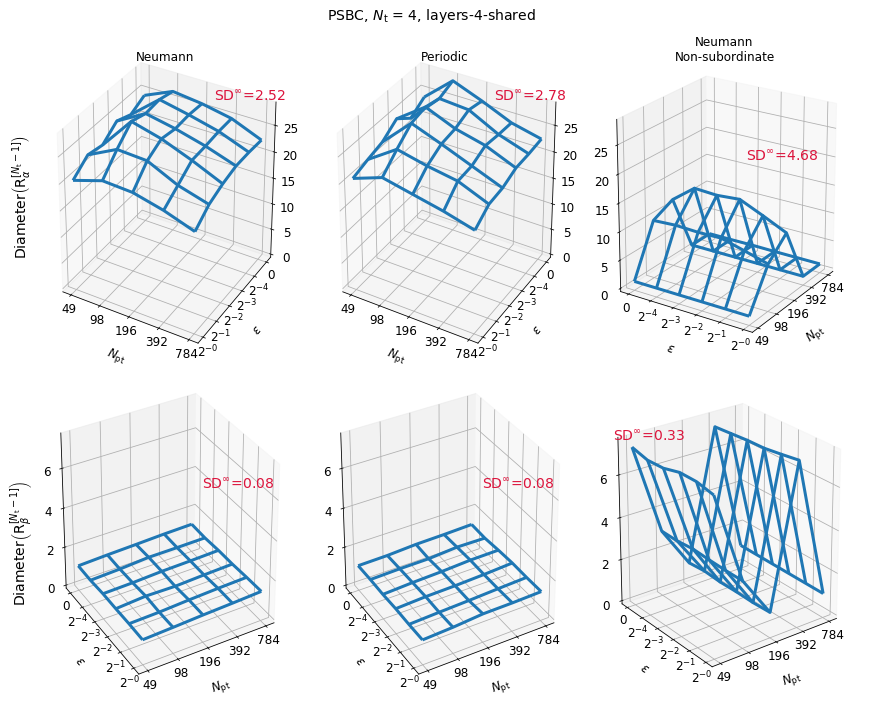

In [42]:
what_is_being_plotted = "mean_diameter_"
info_corner = "std_diameter_"

print_corner = True

Nt = 4
layers_k_shared = 4
variable_0, variable_1 = 0, 1

if Nt ==1:
    axis_view = {1: {0: (20, 120), 1: (20, 120), 2: (22, 42), 3: (20, 50), 4: (20, 50), 5: (10, 30)}}
    height_SD = {1: {0: 1, 1: 1, 2: -5, 3: None, 4: None, 5: 1}}
    pos_label_SD = {1: {0: (0,1), 1: (0,1), 2:  (1,4), 3:  (3.3,0), 4:  (3.3,0), 5:  (3.3,0)}}
    x_labelpad = 2
    y_labelpad = 2
    z_labelpad = 10
elif Nt == 2:
    axis_view = {1: {0: (30, 120), 1: (30, 120), 2: (25, 120),3: (10, 60), 4: (10, 60), 5: (10, 60)},
                 2: {0: (30, 120), 1: (30, 120), 2: (25, 120),3: (10, 60), 4: (10, 60), 5: (10, 60)}}
    height_SD = {1: {0: 3, 1: 3, 2: None, 3: None, 4: None, 5: -2},
                 2: {0: 3, 1: 3, 2: None, 3: None, 4: None, 5: -2}}
    pos_label_SD = {1: {0: (0,1), 1: (0,1), 2:  (0,3.3), 3:  (3.3,0), 4:  (3.3,0), 5:  (0,3)},
                    2: {0: (0,1), 1: (0,1), 2:  (0,3.3), 3:  (3.3,0), 4:  (3.3,0), 5:  (0,3)}}
    x_labelpad = 4
    y_labelpad = 4
    z_labelpad = 10
elif Nt == 4:
    axis_view = {1: {0: (30, 120), 1: (30, 120), 2: (20, 33),3: (30, 60), 4: (30, 60), 5: (6, 43)},
                 4: {0: (30, 120), 1: (30, 120), 2: (20, 33),3: (30, 60), 4: (30, 60), 5: (22, 53)}}
    height_SD = {1: {0: 3, 1: 3, 2: -10, 3: -2, 4: -2, 5: -.5},
                 4: {0: 4.3, 1: 4.3, 2: -10, 3: -2, 4: -2, 5: 0}}
    pos_label_SD = {1: {0: (0,1), 1: (0,1), 2:  (0,3.3), 3:  (0,3.3), 4:  (0,3.3), 5:  (3.4,0)},
                    4: {0: (0,1), 1: (0,1), 2:  (0,3.3), 3:  (0,3.3), 4:  (0,3.3), 5:  (3.4,0)}}
    x_labelpad = 4
    y_labelpad = 4
    z_labelpad = 10

max_p = 1
max_u = 1
nrows = 2 #if Nt != 1 else 1

fig, ax = plt.subplots(
    ncols = 3, nrows = nrows, figsize = (15,6*nrows), #sharey = True,
    gridspec_kw = {'wspace' : .01, 'hspace' : .03}, subplot_kw = {'projection': '3d'})

Xs = np.arange (5) 
Xlabel = [int (784 / k) for k in [1,2,4,8,16]]
Ys = np.arange (6)
Y_label = [test_label (a) for a in np.arange (4,-1,-1)]
Y_label = ["0"] + Y_label

X, Y = np.meshgrid (Xs, Ys)

SD_infty = np.zeros ((2,3), dtype = np.float32)

for col, name  in enumerate (zip (["Neumann", "Periodic", "Neumann_non_subordinate"],\
                                 ["Neumann", "Periodic", "Neumann\nNon-subordinate"])):
    
    col_name, col_title = name 
    
    M_now = Snapshot_best_weights_stats [col_name][Nt]\
    [(variable_0, variable_1)][layers_k_shared]
    
    fig_title_append = str (Nt) + ", layers-" + str (layers_k_shared)+ "-shared"
    fig.suptitle (r"PSBC, $N_{\mathrm{t}}$ = " + fig_title_append, y = .92, size = 14)
    
    ax [0,col].set_title(col_title, y = 1.0)
    
    for row, row_name in enumerate (["U", "P"]):
        
        if row_name == "P":
            if np.less (max_p,np.max (M_now [what_is_being_plotted + row_name])):
                max_p = np.max (M_now [what_is_being_plotted + row_name])
        else:
            if np.less (max_u,np.max (M_now [what_is_being_plotted + row_name])):
                max_u = np.max (M_now [what_is_being_plotted + row_name])
        
        ax [row, col].plot_wireframe(
            X,Y, M_now [what_is_being_plotted+row_name].T,
            alpha = 1, linewidth =3,rstride=1, cstride = 1)
        ax [row,col].set_xlabel (
            r"$N_{\mathrm{pt}}$", labelpad = x_labelpad)
        ax [row,col].set_ylabel (
            r"$\varepsilon$", labelpad = y_labelpad)
        SD_infty[row,col] = np.round(np.max (M_now [info_corner+row_name]),2)
        
fig.text (0.12, 0.7,
          r'Diameter$\left(\mathcal{R}_{\alpha}^{[N_{\mathrm{t}}-1]}\right)$',
          ha = 'center', va = 'center', rotation = 'vertical', size = 14)
fig.text(0.12, 0.3,
         r'Diameter$\left(\mathcal{R}_{\beta}^{[N_{\mathrm{t}}-1]}\right)$',
         ha = 'center', va = 'center', rotation = 'vertical', size = 14)

for col in range (3):
    for row in range (2):
        ax [row,col].set_xticks (Xs)
        ax [row,col].set_xticklabels (Xlabel)
        ax [row,col].set_yticks (Ys)
        ax [row,col].set_yticklabels (Y_label)
        
        for t in ax [row, col].zaxis.get_major_ticks (): t.label.set_fontsize (12)
        for t in ax [row, col].xaxis.get_major_ticks (): t.label.set_fontsize (12)
        for t in ax [row, col].yaxis.get_major_ticks (): t.label.set_fontsize (12)
        
        ax [row,col].view_init (
            axis_view [layers_k_shared][int (col + 3 * row)][0],\
            axis_view [layers_k_shared][int (col + 3 * row)][1])
        if row == 0:
            ax [row,col].set_zlim (0, max_u)
        else:
            ax [row,col].set_zlim (0, max_p)
        ax [row,col].yaxis.set_tick_params (pad = -3)
        
        #if row == 1 and col == 2:
        #    ax [row,col].xaxis.set_tick_params (pad = 1)
        #else:
        ax [row,col].xaxis.set_tick_params (pad = -3)
            
        if print_corner:
            max_now = max_u if row == 0 else max_p
            if height_SD [layers_k_shared][int (col + 3 * row)] == None:
                ax [row, col].text(
                    *pos_label_SD [layers_k_shared][int(col + 3 * row)], max_now,
                    r"$\mathrm{SD}^{\infty}$=" + str (SD_infty [row, col]),
                    ha = "center", va = "center", color = "crimson", size = 14)
            else:
                max_now += height_SD [layers_k_shared][int (col + 3 * row)]
                ax [row, col].text(
                    *pos_label_SD [layers_k_shared][int(col + 3 * row)], max_now,
                    r"$\mathrm{SD}^{\infty}$=" + str (SD_infty [row, col]),
                    ha = "center", va = "center", color = "crimson", size = 14)
plt.tight_layout()

fig_name_save = "max_weights_Nt_" + str (Nt) + "lks_" + str (layers_k_shared)
#figure_save (fig_name_save, resolution =  600, figure_extension = "pdf")
plt.show()

## Getting histories

In [22]:
example_histories = All_histories ["Classifier_196"][2][(8,9)][1][196][0]

As before, there are 5 histories, one for each fold

In [23]:
len (example_histories)

5

We can access the evolution of dt_u, dt_p, the sup of W_u, and W_p during each section

In [24]:
example_histories[0]

{'dt_P': [0.005502431187778711,
  0.003485201857984066,
  0.002866719849407673,
  0.0026007213164120913,
  0.002467749174684286,
  0.002398715354502201,
  0.0023606049362570047,
  0.0023398264311254025,
  0.0023283171467483044,
  0.002322055632248521,
  0.0023186421021819115],
 'dt_U': [0.5699999928474426,
  0.5699999928474426,
  0.5699999928474426,
  0.5699999928474426,
  0.5699999928474426,
  0.5699999928474426,
  0.5699999928474426,
  0.5699999928474426,
  0.5699999928474426,
  0.5699999928474426,
  0.5699999928474426],
 'w_p_inf': [10.177945137023926,
  12.788613319396973,
  14.100833892822266,
  14.804389953613281,
  15.198017120361328,
  15.4151611328125,
  15.53909683227539,
  15.607940673828125,
  15.646469116210938,
  15.667551040649414,
  15.679079055786133],
 'w_u_inf': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}

# Plotting the history, dtu and dtp

Let's initially take a look at the pickled file

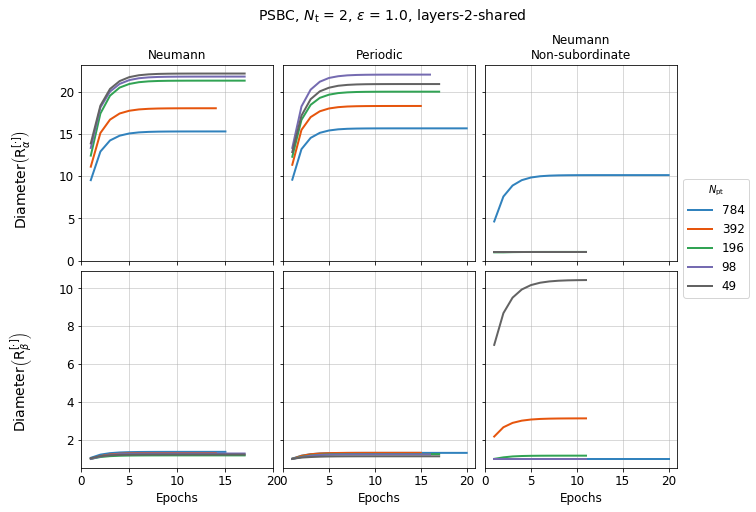

In [30]:
fig, ax = plt.subplots(
    ncols = 3, nrows = 2, figsize = (12,8), sharey = "row", sharex = "col",
    gridspec_kw = {'wspace' : 0.05, 'hspace' : 0.05})

colors = plt.cm.tab20c (np.linspace (0, 1, 6))
titles = ["Neumann", "Periodic", "Neumann\nNon-subordinate"]

Nt = 2
lks = 2
enum_eps = 5
eps_range =  np.r_[[0], np.power (.5, [4,3,2,1,0])]
eps = eps_range [enum_eps]
fold = 0

fig.suptitle (r"PSBC, $N_{\mathrm{t}}$ = " + str (Nt) +\
              r", $\varepsilon$ = " + str (eps)+ ", layers-" + str (lks) + "-shared", y = .9, size = 14)
    
for col, col_name in enumerate (["Neumann", "Periodic", "Neumann_non_subordinate"]):
    weights_now = All_histories [col_name][Nt][(0,1)][lks]

    for enum_k, k in enumerate ([1,2,4,8,16]):
        pt_cdn = int (784 / k) 
        
        ax [0, col].set_title (titles [col])
        ax [0, col].plot (
            np.arange (1, len (weights_now [pt_cdn][enum_eps][fold]["w_u_inf"])+1),
            weights_now [pt_cdn][enum_eps][fold]["w_u_inf"],
            color = colors [enum_k])
        ax [1, col].plot (
            np.arange (1, len (weights_now [pt_cdn][enum_eps][fold]["w_p_inf"])+1),
            weights_now [pt_cdn][enum_eps][fold]["w_p_inf"],
            label =  str (pt_cdn),
            color = colors [enum_k])
        ax [0, col].set_xticks (np.arange (0,21,5))
        ax [1, col].set_xticks (np.arange (0,21,5))
        ax [0, col].grid(True)
        ax [1, col].grid(True)
        ax [1, col].set_xlabel("Epochs")

fig.text (
    0.07, 0.6, r'Diameter$\left(\mathcal{R}_{\alpha}^{[\cdot]}\right)$',
    ha = 'center', va = 'center', rotation = 'vertical', size = 14)
fig.text (
    0.07, 0.25, r'Diameter$\left(\mathcal{R}_{\beta}^{[\cdot]}\right)$',
    ha = 'center', va = 'center', rotation = 'vertical', size = 14)
        
plt.legend(bbox_to_anchor = (1,1.5), loc = "upper left",\
           title = r"$N_{\mathrm{pt}}$", ncol = 1)
fig.subplots_adjust(bottom = 0.1, top = .8, left = 0.14, right = .83)

fig_name_save = IMAGES+ "evolution_sup_weights_N_pt" + str (Nt) + "_lks_" + str (lks) + ".pdf"

### If you want to save the figure, just remove the next comment
#fig.savefig (fig_name_save, resolution =  600, format = 'pdf')

plt.show()

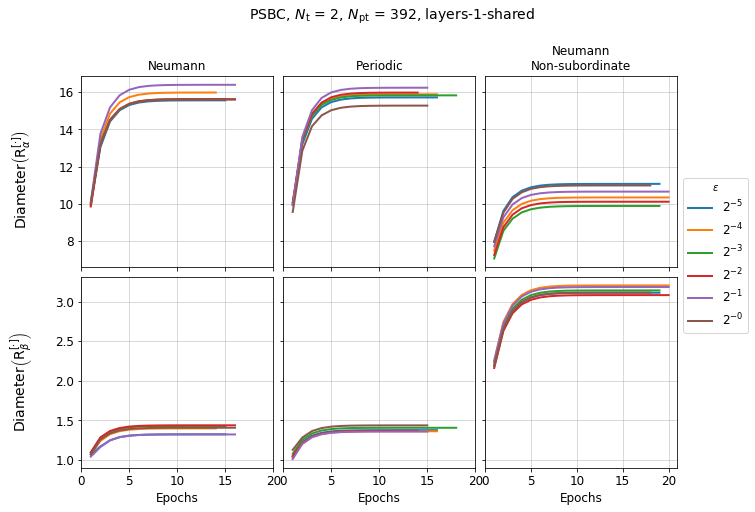

In [28]:
fig, ax = plt.subplots(
    ncols = 3, nrows = 2, figsize = (12,8), sharey = "row", sharex = "col",
    gridspec_kw = {'wspace' : 0.05, 'hspace' : 0.05})

pt_cdn = 392
titles = ["Neumann", "Periodic", "Neumann\nNon-subordinate"]

Nt = 2
lks = 1

eps_range =  np.r_[[0], np.power (.5, [4,3,2,1,0])]
eps = eps_range [enum_eps]
fold = 0
fig.suptitle (r"PSBC, $N_{\mathrm{t}}$ = " + str (Nt) + r", $N_{\mathrm{pt}}$ = " + str (pt_cdn)+\
              ", layers-" + str (lks) + "-shared", y = .9, size = 14)
    
#def test_label(x): return r'$2^{{-{0}}}$'.format(x)

Ys = np.arange (4,-1,-1)
Y_label = [test_label(a) for a in Ys]
Y_label = ["0"]+Y_label

for col, col_name in enumerate (["Neumann", "Periodic", "Neumann_non_subordinate"]):
    weights_now = All_histories [col_name][Nt][(0,1)][lks]
    
    for enum_eps in range (5,-1,-1):
        
        ax [0, col].set_title (titles [col])
        ax [0, col].plot (
            np.arange (1, len (weights_now [pt_cdn][enum_eps][fold]["w_u_inf"])+1),
            weights_now [pt_cdn][enum_eps][fold]["w_u_inf"],
            label =  test_label (enum_eps))
        ax [1, col].plot (
            np.arange (1, len (weights_now [pt_cdn][enum_eps][fold]["w_p_inf"])+1),
            weights_now [pt_cdn][enum_eps][fold]["w_p_inf"],
            label =  test_label (enum_eps))
        ax [0, col].set_xticks (np.arange (0,21,5))
        ax [1, col].set_xticks (np.arange (0,21,5))
        ax [0, col].grid (True)
        ax [1, col].grid (True)
        ax [1, col].set_xlabel ("Epochs")
        
text_1 = fig.text(
    0.07, 0.6,r'Diameter$\left(\mathcal{R}_{\alpha}^{[\cdot]}\right)$',
    ha = 'center', va = 'center', rotation = 'vertical', size = 14)
fig.text (
    0.07, 0.25, r'Diameter$\left(\mathcal{R}_{\beta}^{[\cdot]}\right)$',
    ha = 'center', va = 'center', rotation = 'vertical', size = 14)

lgd = ax [0,2].legend(bbox_to_anchor = (1,.5),\
                      loc = "upper left", title = r"$\varepsilon$", ncol = 1)

fig.subplots_adjust (bottom = 0.1, top = .78, left = .14, right = .83)
fig_name_save = IMAGES + "evolution_sup_weights_eps" + str (Nt) + "_lks_" + str (lks)  + ".pdf"

### If you want to save the figure, just remove the next comment
#fig.savefig (fig_name_save, resolution =  600, format = 'pdf'),

plt.show()